# All Path Motif Analysis


### Install necessary modules

In [1]:
# Installs necessary modules
!pip install GraphRicciCurvature
!pip install scikit-learn

# import sys
# sys.path.append("../")
import networkx as nx
import networkit as nk
import numpy as np
import math

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci


# load python-louvain for modularity computation
import community as community_louvain

# for ARI computation
from sklearn import preprocessing, metrics

### Functions for counting the number of paths of a given pattern

In [2]:
import copy

# Takes in a list of characters from {N,F,P} and a graph with 
# edge curvature attribute. Returns the number of paths from 
# each node with the curvature pattern specified by the input list.
# N means negative curvature, F means neutral curvature, and P 
# means positive curvature. We consider an edge's curvature value to 
# be negative when between [-1, -0.33), flat 
# when between [-0.33, 0.33], and positive when between (0.33,1]. 
# E.g. A sequence of edges with curvatures -0.3, .56, 0 respectively
# would match the input pattern [F, P, F].
def get_paths(G, patt):
    
    # If pattern is empty then there are no matches
    if len(patt) == 0:
        return 0
    else:
        
        # Collects all paths
        all_paths = []
        for x in G.nodes():
            
            # Iteratively puts all_paths back intro function call
            # to append new paths.
            get_paths_helper(G, patt, all_paths, [x], x)
        return all_paths


# Input is a graph, the remaining curvature pattern to be matched, 
# a list to store all the paths, a variable that stores the current path 
# as a sequence of vertices during the recursive work, and the current vertex. 
# Adds paths that, building off of the current path, completely match 
# input pattern to the list of all paths.
# E.g. When cur_path is [v1, v2, v3] and there is an edge (v3, v4) with
# curvature -0.6 and another edge (v4, v5) with curvature 0.1 and another 
# edge (v4, v6) with curvature 0.2 and the remaining pattern is [N, F] then 
# we will add the paths [v1, v2, v3, v4, v5] and [v1, v2, v3, v4, v6] to 
# our total paths list.
def get_paths_helper(G, patt, all_paths, cur_path, cur_vert):
    
    # Base case. When the pattern is empty, the current path is 
    # added to the list of all paths since the current path
    # matched the initial input pattern.
    if len(patt) == 0:
        all_paths.append(copy.copy(cur_path)) 
    else:
        
        # If pattern is not exhausted, then for each neighbor of the
        # current vertex, see if the edge to any of its neighbors
        # matches the next curvature value in the pattern. If so repeat
        # the procedure on those nodes.
        for neighbor in G.neighbors(cur_vert):
            
            # This prevents the algorithms from finding all the walks.
            # We do not want vertices repeated in a path.
            if neighbor in cur_path:
                continue
            
            # Stores the curvature of the edge from the current vertex 
            # to the particular neighbor
            curv = G.get_edge_data(cur_vert, neighbor)['ricciCurvature']
            
            # Condition checks whether the sign of the curvature on the edge
            # matches the corresponding character of the next pattern element.
            if ((patt[0] == 'N') and (curv < -0.33)) or ((patt[0] == 'P') and (curv > 0.33)) or ((patt[0] == 'F') and (curv <= 0.33) and (curv >= -0.33)):
                
                # If the edge has a curvature of the matching sign then
                # the neighbor node is added to the current path.
                cur_path.append(neighbor)
                
                # We recurse on the neighbor node
                get_paths_helper(G, patt[1:], all_paths, cur_path, neighbor)
                
                # We remove the current neighbor node for the next iteration 
                # so we can consider a different neighbor node.
                cur_path.pop()
    return                
   
    
# Returns the number of paths in undirected input graph that 
# match the curvature pattern specified by the variable patt.
def get_num_paths_undir(G, patt):
    all_paths = get_paths(G, patt)
    
    # If the pattern is symmetric then get_paths
    # will have double counted each path (each path will 
    # have been counted for both endnodes).
    if patt == list(reversed(patt)):
        return int(len(all_paths)/2)
    else: 
        return len(all_paths)
    
# Returns the number of paths in directed input graph that 
# match the curvature pattern specified by the variable patt.
def get_num_paths_dir(G, patt):
    all_paths = get_paths(G, patt)
    return len(all_paths)
    


## C. Elegan Analysis

In [3]:
# Reads in C. Elegans Connectome
eleCme = nx.read_graphml("c.elegans_neural.male_1.graphml")

# Self loops are removed since no self loop can be on any path.
# The ricci curvature computation would remove self loops anyway
# so it is best to remove them beforehand. This way when we compute
# random graphs we are not removing a potentially different
# number of self loops each time to compute the curvature.
self_loops = []
for (v, w) in eleCme.edges():
    if v == w:
        self_loops.append(v)
for v in self_loops:
    eleCme.remove_edge(v,v)
    
# Computes Ricci Curvature for C. Elegans Connectome without self-loops
orc = OllivierRicci(eleCme, alpha=0.5, verbose="TRACE")
orc.compute_ricci_curvature()
eleCme_orc = orc.G.copy()

INFO:Edge weight not detected in graph, use "weight" as default edge weight.
TRACE:Number of nodes: 272
TRACE:Number of edges: 4388
TRACE:Start to compute all pair shortest path.
TRACE:0.011935 secs for all pair by NetworKit.
INFO:0.295051 secs for Ricci curvature computation.


In [4]:
# For each path pattern of length 3, stores 
# the number of matches in a dictionary and
# accumulates the total number of paths.
three_patt_count = {}
total_3_paths = 0
for x in ['N', 'F', 'P']:
    for y in ['N', 'F', 'P']:
        for z in ['N', 'F', 'P']:
            num_paths = get_num_paths_dir(eleCme_orc, [x, y, z])
            three_patt_count[(x, y, z)] = num_paths
            total_3_paths = total_3_paths + num_paths
            
# Converts the dictionary of match counts to
# a dictionary of match frequencies relative
# to all matches.
three_patt_freq = {}
for patt in three_patt_count.keys():
    three_patt_freq[patt] = three_patt_count[patt]/total_3_paths
    
# Gets a list of all length three patterns that are matched
# by over 1% of length three paths
relevant_three_patterns = []
for (x,y,z) in three_patt_freq.keys():
    if three_patt_freq[(x,y,z)] >= 0.01:
        relevant_three_patterns.append([x,y,z])
        
# Outputs the length three patterns that have more than 1% matches.
print(relevant_three_patterns)

[['F', 'N', 'F'], ['F', 'F', 'N'], ['F', 'F', 'F']]


In [5]:
three_patt_count

{('N', 'N', 'N'): 186,
 ('N', 'N', 'F'): 1367,
 ('N', 'N', 'P'): 0,
 ('N', 'F', 'N'): 2129,
 ('N', 'F', 'F'): 22351,
 ('N', 'F', 'P'): 79,
 ('N', 'P', 'N'): 0,
 ('N', 'P', 'F'): 0,
 ('N', 'P', 'P'): 0,
 ('F', 'N', 'N'): 4085,
 ('F', 'N', 'F'): 40586,
 ('F', 'N', 'P'): 63,
 ('F', 'F', 'N'): 204638,
 ('F', 'F', 'F'): 2198165,
 ('F', 'F', 'P'): 340,
 ('F', 'P', 'N'): 0,
 ('F', 'P', 'F'): 64,
 ('F', 'P', 'P'): 1,
 ('P', 'N', 'N'): 0,
 ('P', 'N', 'F'): 0,
 ('P', 'N', 'P'): 0,
 ('P', 'F', 'N'): 3,
 ('P', 'F', 'F'): 235,
 ('P', 'F', 'P'): 0,
 ('P', 'P', 'N'): 0,
 ('P', 'P', 'F'): 0,
 ('P', 'P', 'P'): 0}

In [53]:
# For each path pattern of length 4, stores 
# the number of matches in a dictionary and
# accumulates the total number of paths.
four_patt_count = {}
total_4_paths = 0
for x in ['N', 'F', 'P']:
    for y in ['N', 'F', 'P']:
        for z in ['N', 'F', 'P']:
            for w in ['N', 'F', 'P']:
                num_paths = get_num_paths_dir(eleCme_orc, [x, y, z, w])
                four_patt_count[(x, y, z, w)] = num_paths
                total_4_paths = total_4_paths + num_paths
                
# Converts the dictionary of match counts to
# a dictionary of match frequencies relative
# to all matches.
four_patt_freq = {}
for patt in four_patt_count.keys():
    four_patt_freq[patt] = four_patt_count[patt]/total_4_paths

    
# Gets a list of all length four patterns that are matched 
# by over 1% of length four paths
relevant_four_patterns = []
for (x,y,z,w) in four_patt_freq.keys():
    if four_patt_freq[(x,y,z,w)] >= 0.01:
        relevant_four_patterns.append([x,y,z,w])

# Outputs the length four patterns that have more than 1% matches.
relevant_four_patterns

### Null hypothesis  testing

In [6]:
# Gets n random graphs that preserve the degree sequence 
# of the input graph (which is in networkX format).
# Returns a list of these graphs.
def get_null_graphs(G_nx, n):
    
    # Converts to networkit graph
    G = nk.nxadapter.nx2nk(G_nx, weightAttr=None)
    null_graphs = []
    for i in range(n):
        
        # Computes a degree sequence preserving random graph
        sampledGraph = nk.nxadapter.nk2nx(nk.randomization.GlobalCurveball(G, number_of_global_rounds=20, allowSelfLoops=False, degreePreservingShufflePreprocessing=True).run().getGraph())
        
        # Computes Ollivier-Ricci curvature of this graph
        orc = OllivierRicci(sampledGraph, alpha=0.5, verbose="ERROR")
        orc.compute_ricci_curvature()
        G_orc = orc.G.copy()
        null_graphs.append(G_orc)
    return null_graphs

# Given a list of directed null graphs, a file name, and a 
# list of paterns, stores the number of paths that match
# that pattern in each graph. File is formatted so each line
# is "pattern #matchG1 #matchG2 ..., #matchGn" where #matchGi is
# the number of paths that match the given pattern in graph i.
def write_null_vals_dir(null_graphs, filename, patts):
    with open(filename, 'w') as f:
        for patt in patts:
            f.write(str(patt))
            for null_graph in null_graphs:
                num = get_num_paths_dir(null_graph, patt)
                f.write(' %d' % num)
            f.write('\n')
            
            

In [7]:
import pickle

# Stores the sample of 1000 null graphs in a file. Commented out since already computed.

#null_graphs = get_null_graphs(eleCme, 1000)
#with open("null_graphs", 'wb') as f:
#    pickle.dump(null_graphs, f)

In [8]:
# Returns the number of null graphs 
def null_graphs():
    null_graphs = []
    with open("null_graphs", 'rb') as f:
        null_graphs = pickle.load(f)
    return null_graphs

In [9]:
# Computes number of matches for ['F', 'F', 'F'] pattern 
# in each null graph and stores the result in a file.
# May take awhile to run. Commented out since already computed

#write_null_vals_dir(null_graphs(), 'CElegans-allpaths-3-Motifs-[F, F, F].txt', 
#                [['F', 'F', 'F']])

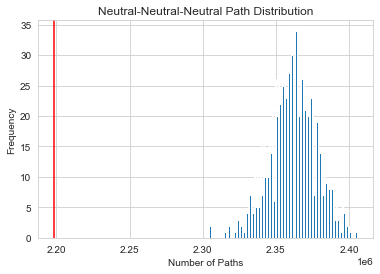

In [10]:
# Visualizes null distribution for [F, F, F] pattern
nul_vals = []
patts = []
with open('CElegans-allpaths-3-Motifs-[F, F, F].txt') as f:
    for line in f:
        temp = line.split()
        patt = temp[0]+temp[1]+temp[2]
        vals = [int(i) for i in temp[3:]]
        patts.append(patt)
        nul_vals.append(vals)
        
plt.hist(nul_vals[0], 100)
plt.title("Neutral-Neutral-Neutral Path Distribution")
plt.xlabel("Number of Paths")
plt.ylabel("Frequency")

# Draws line at the number of matches in C. Elegans
plt.axvline(x = get_num_paths_dir(eleCme_orc, ['F', 'F', 'F']), color = 'r')

In [12]:
# Computes number of matches for ['F', 'N', 'F'] and ['F', 'F', 'N'] 
# patterns in each null graph and stores the result in a file.
# Commented out since already stored.

write_null_vals_dir(null_graphs(), 'CElegans-allpaths-3-Motifs-[F, N, F]-[F, F, N].txt', 
                [['F', 'N', 'F'], ['F', 'F', 'N']])

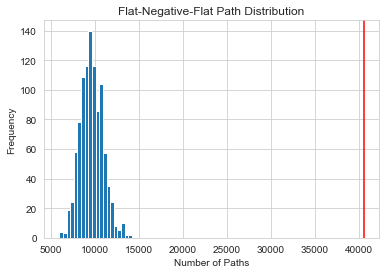

In [17]:
# Visualizes null distribution
nul_vals = []
patts = []
with open('CElegans-allpaths-3-Motifs-[F, N, F]-[F, F, N].txt') as f:
    for line in f:
        temp = line.split()
        patt = temp[0]+temp[1]+temp[2]
        vals = [int(i) for i in temp[3:]]
        patts.append(patt)
        nul_vals.append(vals)
        
plt.hist(nul_vals[0], 20)
plt.title("Flat-Negative-Flat Path Distribution")
plt.xlabel("Number of Paths")
plt.ylabel("Frequency")

# Draws line at the number of matches in C. Elegans
plt.axvline(x = get_num_paths_dir(eleCme_orc, ['F', 'N', 'F']), color = 'r')

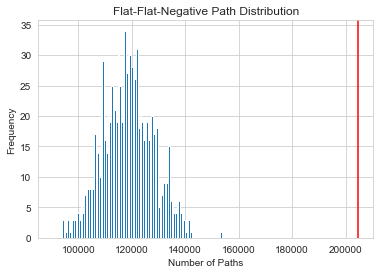

In [16]:
# Visualizes null distribution
plt.hist(nul_vals[1], 100)
plt.title("Flat-Flat-Negative Path Distribution")
plt.xlabel("Number of Paths")
plt.ylabel("Frequency")

# Draws line at the number of matches in C. Elegans
plt.axvline(x = get_num_paths_dir(eleCme_orc, ['F', 'F', 'N']), color = 'r')

### Shortest Path Analysis

# Testing

In [7]:
import scipy

# Finds the number of 2-paths in a directed graph using the path motif algorithm
def num_2paths_dir(G_orc): 
    return (get_num_paths_dir(G_orc, ['N', 'N'])+get_num_paths_dir(G_orc, ['P', 'P'])
            +get_num_paths_dir(G_orc, ['P', 'N'])+get_num_paths_dir(G_orc, ['N', 'P'])
            +get_num_paths_dir(G_orc, ['P', 'F'])+get_num_paths_dir(G_orc, ['F', 'P'])
            +get_num_paths_dir(G_orc, ['N', 'F'])+get_num_paths_dir(G_orc, ['F', 'N'])
            +get_num_paths_dir(G_orc, ['F', 'F']))

def num_3paths_dir(G_orc): 
    return (get_num_paths_dir(G_orc, ['N', 'N', 'N'])+get_num_paths_dir(G_orc, ['F', 'F', 'F'])+get_num_paths_dir(G_orc, ['P', 'P','P'])
            +get_num_paths_dir(G_orc, ['N', 'N', 'F'])+get_num_paths_dir(G_orc, ['F', 'F', 'N'])+get_num_paths_dir(G_orc, ['P', 'P','N'])
            +get_num_paths_dir(G_orc, ['N', 'N', 'P'])+get_num_paths_dir(G_orc, ['F', 'F', 'P'])+get_num_paths_dir(G_orc, ['P', 'P','F'])
            +get_num_paths_dir(G_orc, ['N', 'F', 'N'])+get_num_paths_dir(G_orc, ['F', 'N', 'F'])+get_num_paths_dir(G_orc, ['P', 'F','P'])
            +get_num_paths_dir(G_orc, ['N', 'F', 'F'])+get_num_paths_dir(G_orc, ['F', 'N', 'N'])+get_num_paths_dir(G_orc, ['P', 'F','N'])
            +get_num_paths_dir(G_orc, ['N', 'F', 'P'])+get_num_paths_dir(G_orc, ['F', 'N', 'P'])+get_num_paths_dir(G_orc, ['P', 'F','F'])
            +get_num_paths_dir(G_orc, ['N', 'P', 'N'])+get_num_paths_dir(G_orc, ['F', 'P', 'F'])+get_num_paths_dir(G_orc, ['P', 'N','P'])
            +get_num_paths_dir(G_orc, ['N', 'P', 'F'])+get_num_paths_dir(G_orc, ['F', 'P', 'N'])+get_num_paths_dir(G_orc, ['P', 'N','N'])
            +get_num_paths_dir(G_orc, ['N', 'P', 'P'])+get_num_paths_dir(G_orc, ['F', 'P', 'P'])+get_num_paths_dir(G_orc, ['P', 'N','P']))



In [ ]:
# Checks that we can recover total number of 
# 2 paths for a small directed graph for which I was
# also able to verify all quantities by hand.
B = np.array([[0,1,1,0], [0,0,1,0], [0,1,0,1], [0,0,0,0]])
G = nx.DiGraph(B)
orc = OllivierRicci(G, alpha=0.5, verbose="TRACE")
orc.compute_ricci_curvature()
G_orc = orc.G.copy()
print(num_2paths_dir(G_orc) == 4) 
print(num_3paths_dir(G_orc) == 1) 